In [ ]:
# !pip install https://github.com/maciejkula/spotlight/archive/master.zip

## Accessing data set

In [1]:
"""
Utilities for fetching the Movielens datasets [1]_.

References
----------

.. [1] https://grouplens.org/datasets/movielens/
"""

import os

import h5py

from spotlight.datasets import _transport
from spotlight.interactions import Interactions

VARIANTS = ('100K',
            '1M',
            '10M',
            '20M')


URL_PREFIX = ('https://github.com/maciejkula/recommender_datasets/'
              'releases/download')
VERSION = 'v0.2.0'


def _get_movielens(dataset):

    extension = '.hdf5'

    path = _transport.get_data('/'.join((URL_PREFIX,
                                         VERSION,
                                         dataset + extension)),
                               os.path.join('movielens', VERSION),
                               'movielens_{}{}'.format(dataset,
                                                       extension))

    with h5py.File(path, 'r') as data:
        return (data['/user_id'][:],
                data['/item_id'][:],
                data['/rating'][:],
                data['/timestamp'][:])


def get_movielens_dataset(variant='100K'):
    """
    Download and return one of the Movielens datasets.

    Parameters
    ----------

    variant: string, optional
         String specifying which of the Movielens datasets
         to download. One of ('100K', '1M', '10M', '20M').

    Returns
    -------

    Interactions: :class:`spotlight.interactions.Interactions`
        instance of the interactions class
    """

    if variant not in VARIANTS:
        raise ValueError('Variant must be one of {}, '
                         'got {}.'.format(VARIANTS, variant))

    url = 'movielens_{}'.format(variant)

    return Interactions(*_get_movielens(url))

In [ ]:
dataset = get_movielens_dataset(variant='100K')  
print(dataset.__dict__)  


<Interactions dataset (944 users x 1683 items x 100000 interactions)>

In [3]:
import pandas as pd

df = pd.DataFrame({
    'user_id': dataset.user_ids,
    'item_id': dataset.item_ids,
    'rating': dataset.ratings,
    'timestamp': dataset.timestamps
})

df


,user_id,item_id,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596
...,...,...,...,...
99995,880,476,3.0,880175444
99996,716,204,5.0,879795543
99997,276,1090,1.0,874795795
99998,13,225,2.0,882399156


#### Machine learning ideas based on dataframe output above

- Easiest approach would be clustering 
- One user gives items that they rank the highest, then cluster based on other users with similar ranks
- Ouput the 10 highest rated movies in that cluster

- Also, take into consideration the number of votes (as in a high number and good rating should weigh more)
- Also also, one could add another dimension to the clustering (the timestamp) in order to perhaps give an output like "This is what others with similar intersts are watching currently". This could help our machine learning algorithm cover trends within clusters as well.

# Data visualization and exploration

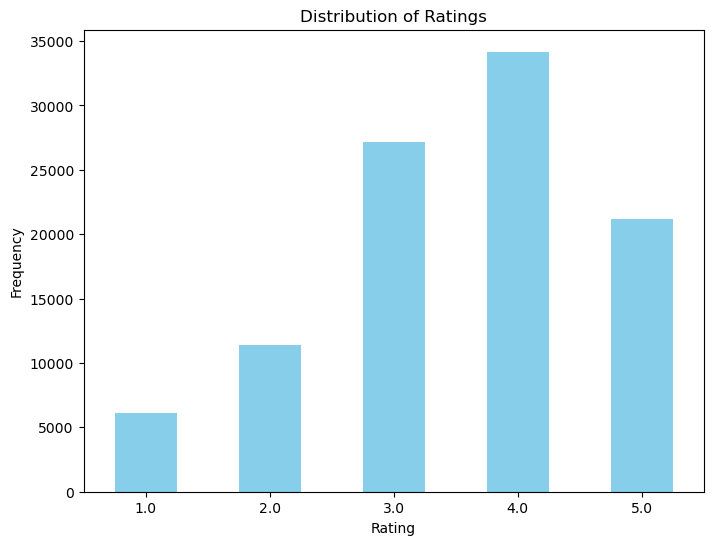

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
df['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()


item_id
50     583
258    509
100    508
181    507
294    485
286    481
288    478
1      452
300    431
121    429
dtype: int64


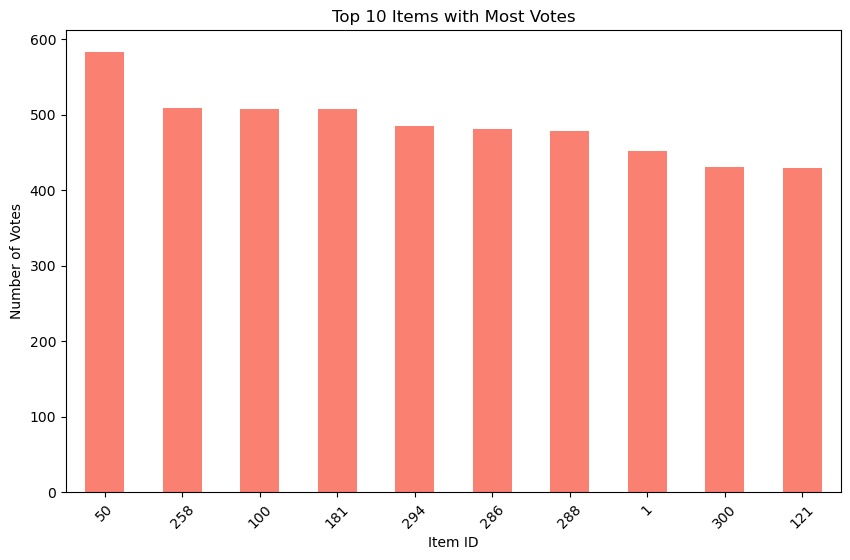

In [5]:
top_items = df.groupby('item_id').size().sort_values(ascending=False).head(10)
print(top_items)
top_items.plot(kind='bar', figsize=(10, 6), color='salmon')
plt.title('Top 10 Items with Most Votes')
plt.xlabel('Item ID')
plt.ylabel('Number of Votes')
plt.xticks(rotation=45)
plt.show()


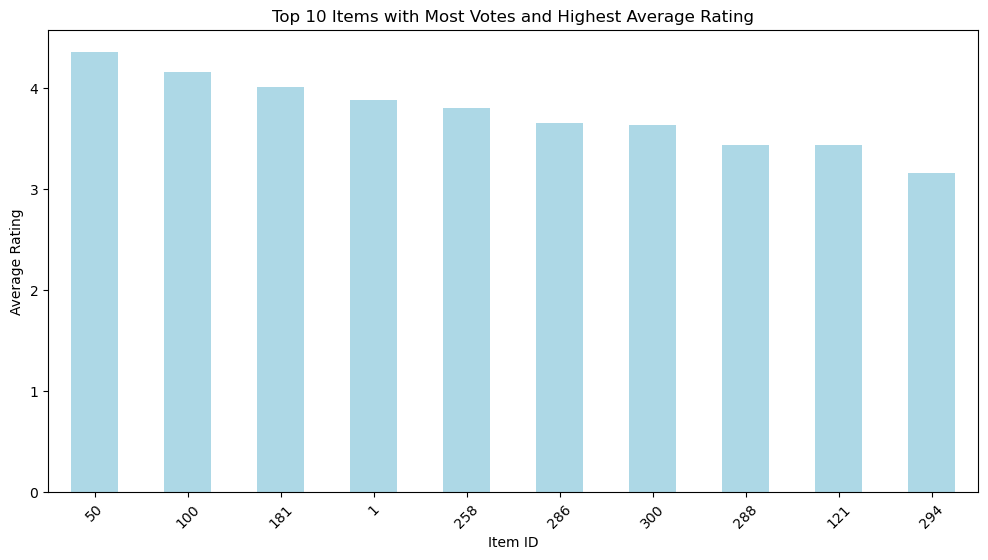

In [6]:
top_items = df.groupby('item_id').size().sort_values(ascending=False).head(10)

avg_ratings = df[df['item_id'].isin(top_items.index)].groupby('item_id')['rating'].mean()

top_items_avg_rating = avg_ratings.loc[top_items.index].sort_values(ascending=False)

plt.figure(figsize=(12, 6))
top_items_avg_rating.plot(kind='bar', color='lightblue')
plt.title('Top 10 Items with Most Votes and Highest Average Rating')
plt.xlabel('Item ID')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()


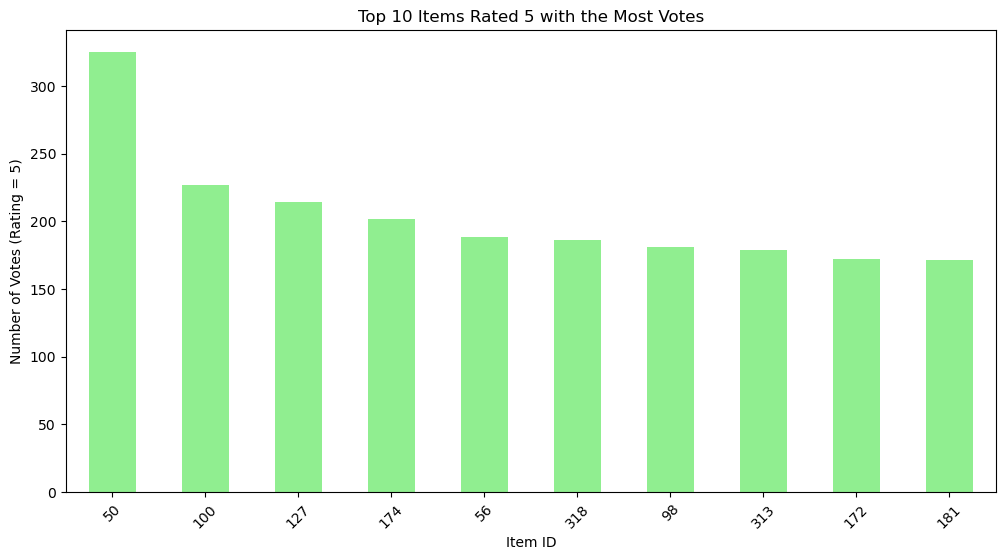

In [7]:
rating_5_df = df[df['rating'] == 5]

votes_count = rating_5_df.groupby('item_id').size().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
votes_count.plot(kind='bar', color='lightgreen')
plt.title('Top 10 Items Rated 5 with the Most Votes')
plt.xlabel('Item ID')
plt.ylabel('Number of Votes (Rating = 5)')
plt.xticks(rotation=45)
plt.show()


## ML Algorithm

In [8]:
import pandas as pd
import numpy as np

user_movie_matrix = df.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0)

print(f"Matrix shape: {user_movie_matrix.shape}")

user_movie_matrix.head()


Matrix shape: (943, 1682)


item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### KNN algorithm (10 highest rated movies of the 3 closest users)

In [9]:
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

user_movie_matrix = df.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0)

new_user_ratings = {
    242: 5,  # Movie ID 242 rated 5
    302: 4,  # Movie ID 302 rated 4
    377: 3,  # Movie ID 377 rated 3
    346: 2,  # Movie ID 346 rated 2
    1090: 1, # Movie ID 1090 rated 1
    51: 5,   # Movie ID 51 rated 5
    225: 4,  # Movie ID 225 rated 4
    203: 3,  # Movie ID 203 rated 3
    476: 2,  # Movie ID 476 rated 2
    204: 1   # Movie ID 204 rated 1
}

new_user_vector = np.zeros(user_movie_matrix.shape[1])  
for movie_id, rating in new_user_ratings.items():
    if movie_id in user_movie_matrix.columns:
        new_user_vector[user_movie_matrix.columns.get_loc(movie_id)] = rating

user_movie_matrix_normalized = normalize(user_movie_matrix, axis=1)

knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(user_movie_matrix_normalized)

new_user_vector_normalized = normalize([new_user_vector], axis=1)

distances, indices = knn_model.kneighbors(new_user_vector_normalized, n_neighbors=3)

closest_users_ids = user_movie_matrix.index[indices[0]]

top_rated_movies = (
    user_movie_matrix.loc[closest_users_ids]
    .mean(axis=0)
    .sort_values(ascending=False)
    .head(10)
)

top_rated_movies_with_individuals = user_movie_matrix.loc[closest_users_ids].T.loc[top_rated_movies.index]
top_rated_movies_with_individuals["Mean Rating"] = top_rated_movies

print(f"Closest user IDs: {list(closest_users_ids)}")
print("Top 10 movies based on closest users' ratings:")
print(top_rated_movies_with_individuals)


Closest user IDs: [485, 651, 740]
Top 10 movies based on closest users' ratings:
user_id  485  651  740  Mean Rating
item_id                            
302      5.0  5.0  5.0     5.000000
242      5.0  5.0  4.0     4.666667
269      4.0  5.0  4.0     4.333333
286      2.0  4.0  5.0     3.666667
288      3.0  0.0  4.0     2.333333
289      3.0  0.0  4.0     2.333333
319      3.0  0.0  3.0     2.000000
332      0.0  3.0  3.0     2.000000
294      1.0  1.0  4.0     2.000000
322      0.0  3.0  3.0     2.000000


### Update list if any of those movies are already seen

In [10]:
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

user_movie_matrix = df.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0)

new_user_ratings = {
    242: 5,  # Movie ID 242 rated 5
    302: 4,  # Movie ID 302 rated 4
    377: 3,  # Movie ID 377 rated 3
    346: 2,  # Movie ID 346 rated 2
    1090: 1, # Movie ID 1090 rated 1
    51: 5,   # Movie ID 51 rated 5
    225: 4,  # Movie ID 225 rated 4
    203: 3,  # Movie ID 203 rated 3
    476: 2,  # Movie ID 476 rated 2
    204: 1   # Movie ID 204 rated 1
}

new_user_vector = np.zeros(user_movie_matrix.shape[1]) 
for movie_id, rating in new_user_ratings.items():
    if movie_id in user_movie_matrix.columns:
        new_user_vector[user_movie_matrix.columns.get_loc(movie_id)] = rating

user_movie_matrix_normalized = normalize(user_movie_matrix, axis=1)

knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(user_movie_matrix_normalized)

new_user_vector_normalized = normalize([new_user_vector], axis=1)

distances, indices = knn_model.kneighbors(new_user_vector_normalized, n_neighbors=3)

closest_users_ids = user_movie_matrix.index[indices[0]]

top_rated_movies = (
    user_movie_matrix.loc[closest_users_ids]
    .mean(axis=0)
    .sort_values(ascending=False)
)

top_rated_movies_with_individuals = user_movie_matrix.loc[closest_users_ids].T.loc[top_rated_movies.index]
top_rated_movies_with_individuals["Mean Rating"] = top_rated_movies

recommended_movies = []
i = 0  
while len(recommended_movies) < 10 and i < len(top_rated_movies):
    movie_id = top_rated_movies.index[i]
    if movie_id not in new_user_ratings:  
        recommended_movies.append(movie_id)
    i += 1

updated_recommendations = top_rated_movies_with_individuals.loc[recommended_movies]
print(f"Closest user IDs: {list(closest_users_ids)}")
print("Top recommended movies (excluding those already rated by the new user):")
print(updated_recommendations)


Closest user IDs: [485, 651, 740]
Top recommended movies (excluding those already rated by the new user):
user_id  485  651  740  Mean Rating
item_id                            
269      4.0  5.0  4.0     4.333333
286      2.0  4.0  5.0     3.666667
288      3.0  0.0  4.0     2.333333
289      3.0  0.0  4.0     2.333333
319      3.0  0.0  3.0     2.000000
332      0.0  3.0  3.0     2.000000
294      1.0  1.0  4.0     2.000000
322      0.0  3.0  3.0     2.000000
515      0.0  5.0  0.0     1.666667
889      5.0  0.0  0.0     1.666667


In [11]:
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

user_movie_matrix = df.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0)

new_user_ratings = {
    242: 5,  # Movie ID 242 rated 5
    302: 4,  # Movie ID 302 rated 4
    377: 3,  # Movie ID 377 rated 3
    346: 2,  # Movie ID 346 rated 2
    1090: 1, # Movie ID 1090 rated 1
    51: 5,   # Movie ID 51 rated 5
    225: 4,  # Movie ID 225 rated 4
    203: 3,  # Movie ID 203 rated 3
    476: 2,  # Movie ID 476 rated 2
    204: 1   # Movie ID 204 rated 1
}

new_user_vector = np.zeros(user_movie_matrix.shape[1]) 
for movie_id, rating in new_user_ratings.items():
    if movie_id in user_movie_matrix.columns:
        new_user_vector[user_movie_matrix.columns.get_loc(movie_id)] = rating

user_movie_matrix_normalized = normalize(user_movie_matrix, axis=1)

knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(user_movie_matrix_normalized)

new_user_vector_normalized = normalize([new_user_vector], axis=1)

distances, indices = knn_model.kneighbors(new_user_vector_normalized, n_neighbors=3)

closest_users_ids = user_movie_matrix.index[indices[0]]

top_rated_movies = (
    user_movie_matrix.loc[closest_users_ids]
    .mean(axis=0)
    .sort_values(ascending=False)
)

top_rated_movies_with_individuals = user_movie_matrix.loc[closest_users_ids].T.loc[top_rated_movies.index]
top_rated_movies_with_individuals["Mean Rating"] = top_rated_movies

print("Original top 10 movies based on closest users' ratings:")
print(top_rated_movies_with_individuals.head(10))

recommended_movies = []
i = 0  
already_seen_movies = []  
while len(recommended_movies) < 10 and i < len(top_rated_movies):
    movie_id = top_rated_movies.index[i]
    if movie_id not in new_user_ratings:  
        recommended_movies.append(movie_id)
    else:
        already_seen_movies.append(movie_id)  
    i += 1

updated_recommendations = top_rated_movies_with_individuals.loc[recommended_movies]
print(f"\nNew user has already seen the following movies: {already_seen_movies}")
print("List is therefore updated.")
print("\nUpdated top recommended movies (excluding those already rated by the new user):")
print(updated_recommendations)


Original top 10 movies based on closest users' ratings:
user_id  485  651  740  Mean Rating
item_id                            
302      5.0  5.0  5.0     5.000000
242      5.0  5.0  4.0     4.666667
269      4.0  5.0  4.0     4.333333
286      2.0  4.0  5.0     3.666667
288      3.0  0.0  4.0     2.333333
289      3.0  0.0  4.0     2.333333
319      3.0  0.0  3.0     2.000000
332      0.0  3.0  3.0     2.000000
294      1.0  1.0  4.0     2.000000
322      0.0  3.0  3.0     2.000000

New user has already seen the following movies: [302, 242]
List is therefore updated.

Updated top recommended movies (excluding those already rated by the new user):
user_id  485  651  740  Mean Rating
item_id                            
269      4.0  5.0  4.0     4.333333
286      2.0  4.0  5.0     3.666667
288      3.0  0.0  4.0     2.333333
289      3.0  0.0  4.0     2.333333
319      3.0  0.0  3.0     2.000000
332      0.0  3.0  3.0     2.000000
294      1.0  1.0  4.0     2.000000
322      0.0  3.0  3

## Try with 10 neighbors instead

In [ ]:
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

user_movie_matrix = df.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=3)

new_user_ratings = {
    242: 5,  # Movie ID 242 rated 5
    302: 4,  # Movie ID 302 rated 4
    377: 3,  # Movie ID 377 rated 3
    346: 2,  # Movie ID 346 rated 2
    1090: 1, # Movie ID 1090 rated 1
    51: 5,   # Movie ID 51 rated 5
    225: 4,  # Movie ID 225 rated 4
    203: 3,  # Movie ID 203 rated 3
    476: 2,  # Movie ID 476 rated 2
    204: 1   # Movie ID 204 rated 1
}

new_user_vector = np.zeros(user_movie_matrix.shape[1])  
for movie_id, rating in new_user_ratings.items():
    if movie_id in user_movie_matrix.columns:
        new_user_vector[user_movie_matrix.columns.get_loc(movie_id)] = rating

user_movie_matrix_normalized = normalize(user_movie_matrix, axis=1)

knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(user_movie_matrix_normalized)

new_user_vector_normalized = normalize([new_user_vector], axis=1)

distances, indices = knn_model.kneighbors(new_user_vector_normalized, n_neighbors=10) 

closest_users_ids = user_movie_matrix.index[indices[0]]

top_rated_movies = (
    user_movie_matrix.loc[closest_users_ids]
    .apply(lambda x: x[x > 0].mean(), axis=0)  
    .sort_values(ascending=False)
)

top_rated_movies_with_individuals = user_movie_matrix.loc[closest_users_ids].T.loc[top_rated_movies.index]
top_rated_movies_with_individuals["Mean Rating"] = top_rated_movies

print("Original top 10 movies based on closest users' ratings:")
print(top_rated_movies_with_individuals.head(10))

recommended_movies = []
i = 0  
already_seen_movies = []  
while len(recommended_movies) < 10 and i < len(top_rated_movies):
    movie_id = top_rated_movies.index[i]
    if movie_id not in new_user_ratings:  
        recommended_movies.append(movie_id)
    else:
        already_seen_movies.append(movie_id)  
    i += 1

updated_recommendations = top_rated_movies_with_individuals.loc[recommended_movies]
print(f"\nNew user has already seen the following movies: {already_seen_movies}")
print("List is therefore updated.")
print("\nUpdated top recommended movies (excluding those already rated by the new user):")
print(updated_recommendations)


Original top 10 movies based on closest users' ratings:
user_id   18  532  523  354  472  416  697    1  771  592  Mean Rating
item_id                                                               
1        5.0  5.0  5.0  3.0  5.0  5.0  5.0  5.0  5.0  4.0          4.7
242      5.0  4.0  5.0  5.0  3.0  4.0  5.0  5.0  4.0  5.0          4.5
50       4.0  3.0  5.0  4.0  5.0  5.0  5.0  5.0  4.0  5.0          4.5
100      5.0  5.0  3.0  5.0  5.0  5.0  3.0  5.0  3.0  5.0          4.4
168      3.0  5.0  4.0  5.0  5.0  5.0  3.0  5.0  3.0  5.0          4.3
258      3.0  3.0  5.0  4.0  5.0  5.0  3.0  5.0  5.0  5.0          4.3
181      3.0  5.0  5.0  4.0  5.0  5.0  4.0  5.0  4.0  3.0          4.3
204      3.0  5.0  5.0  3.0  5.0  5.0  3.0  5.0  3.0  5.0          4.2
191      4.0  5.0  3.0  4.0  5.0  5.0  3.0  5.0  3.0  5.0          4.2
12       5.0  5.0  3.0  3.0  5.0  5.0  3.0  5.0  3.0  5.0          4.2

New user has already seen the following movies: [1, 242]
List is therefore updated.

Update

As seen, its a bit biased since 1 user putting a 5 weighs more than two users putting a 5 and one a 4 for example. 

### Try with different new user input just to check if it works

In [65]:
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

user_movie_matrix = df.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=3)

new_user_ratings = {
    242: 1,  # Movie ID 242 rated 5
    302: 1,  # Movie ID 302 rated 4
    377: 3,  # Movie ID 377 rated 3
    346: 5,  # Movie ID 346 rated 2
    1090: 5, # Movie ID 1090 rated 1
    51: 1,   # Movie ID 51 rated 5
    225: 1,  # Movie ID 225 rated 4
    203: 3,  # Movie ID 203 rated 3
    476: 2,  # Movie ID 476 rated 2
    204: 5   # Movie ID 204 rated 1
}

new_user_vector = np.zeros(user_movie_matrix.shape[1]) 
for movie_id, rating in new_user_ratings.items():
    if movie_id in user_movie_matrix.columns:
        new_user_vector[user_movie_matrix.columns.get_loc(movie_id)] = rating
print("New User Vector: ", new_user_vector.sum())
user_movie_matrix_normalized = normalize(user_movie_matrix, axis=1)

knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(user_movie_matrix_normalized)

new_user_vector_normalized = normalize([new_user_vector], axis=1)

distances, indices = knn_model.kneighbors(new_user_vector_normalized, n_neighbors=10) 

closest_users_ids = user_movie_matrix.index[indices[0]]

top_rated_movies = (
    user_movie_matrix.loc[closest_users_ids]
    .apply(lambda x: x[x > 0].mean(), axis=0)  
    .sort_values(ascending=False)
)

top_rated_movies_with_individuals = user_movie_matrix.loc[closest_users_ids].T.loc[top_rated_movies.index]
top_rated_movies_with_individuals["Mean Rating"] = top_rated_movies

print("Original top 10 movies based on closest users' ratings:")
print(top_rated_movies_with_individuals.head(10))

recommended_movies = []
i = 0  
already_seen_movies = []  
while len(recommended_movies) < 10 and i < len(top_rated_movies):
    movie_id = top_rated_movies.index[i]
    if movie_id not in new_user_ratings:  
        recommended_movies.append(movie_id)
    else:
        already_seen_movies.append(movie_id)  
    i += 1

updated_recommendations = top_rated_movies_with_individuals.loc[recommended_movies]
print(f"\nNew user has already seen the following movies: {already_seen_movies}")
print("List is therefore updated.")
print("\nUpdated top recommended movies (excluding those already rated by the new user):")
updated_recommendations


New User Vector:  27.0
Original top 10 movies based on closest users' ratings:
user_id  532  880  592  425  334  201  474  458  551  851  Mean Rating
item_id                                                               
127      5.0  5.0  5.0  4.0  4.0  5.0  5.0  5.0  5.0  5.0          4.8
12       5.0  5.0  5.0  5.0  5.0  4.0  5.0  5.0  4.0  4.0          4.7
56       3.0  5.0  5.0  5.0  4.0  5.0  5.0  5.0  5.0  5.0          4.7
302      5.0  5.0  5.0  5.0  5.0  4.0  5.0  5.0  3.0  5.0          4.7
346      5.0  5.0  4.0  5.0  5.0  4.0  5.0  4.0  4.0  5.0          4.6
318      5.0  5.0  5.0  2.0  4.0  5.0  5.0  4.0  5.0  5.0          4.5
100      5.0  5.0  5.0  4.0  5.0  4.0  5.0  4.0  4.0  3.0          4.4
603      5.0  5.0  5.0  3.0  5.0  4.0  5.0  4.0  5.0  3.0          4.4
79       5.0  4.0  4.0  4.0  4.0  4.0  5.0  5.0  5.0  4.0          4.4
234      5.0  5.0  5.0  3.0  3.0  5.0  5.0  4.0  4.0  4.0          4.3

New user has already seen the following movies: [302, 346, 204]
List

user_id,532,880,592,425,334,201,474,458,551,851,Mean Rating
item_id,,,,,,,,,,,
127,5.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,4.8
12,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0,4.0,4.7
56,3.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,4.7
318,5.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,5.0,5.0,4.5
100,5.0,5.0,5.0,4.0,5.0,4.0,5.0,4.0,4.0,3.0,4.4
603,5.0,5.0,5.0,3.0,5.0,4.0,5.0,4.0,5.0,3.0,4.4
79,5.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,4.0,4.4
234,5.0,5.0,5.0,3.0,3.0,5.0,5.0,4.0,4.0,4.0,4.3
11,5.0,4.0,5.0,3.0,4.0,4.0,5.0,3.0,5.0,5.0,4.3


In [60]:
recommendations = pd.DataFrame({updated_recommendations.index.name: updated_recommendations.index, "rating": updated_recommendations['Mean Rating']}).to_dict("records")
recommendations

[{'item_id': 127, 'rating': 4.800000190734863},
 {'item_id': 12, 'rating': 4.699999809265137},
 {'item_id': 56, 'rating': 4.699999809265137},
 {'item_id': 318, 'rating': 4.5},
 {'item_id': 100, 'rating': 4.400000095367432},
 {'item_id': 603, 'rating': 4.400000095367432},
 {'item_id': 79, 'rating': 4.400000095367432},
 {'item_id': 234, 'rating': 4.300000190734863},
 {'item_id': 11, 'rating': 4.300000190734863},
 {'item_id': 98, 'rating': 4.300000190734863}]

In [19]:
import pickle
with open("user_movie_matrix.pkl", "wb") as f:
    pickle.dump(user_movie_matrix, f)

# Code fully complete and works! 

Users that were missing ratings for movies were given a rating of "3" instead of a 0 to not get a too biased rating due to missing values. There is probably a better approach to this that weights the ratings instead, but it is yet to be implemented in this code.

Further reflection:
A downside to the KNN is the curese of dimensionality, which we risk by having each movie as its own dimension and then having so many movies in our data set. This was dealt with by normalizing the user-item matrix, reducing the impact of differences in movie popularity, and by using cosine similarity, which focuses on the relative differences between users rather than the absolute magnitude of their ratings. Additionally, dimensionality reduction techniques such as PCA (Principal Component Analysis) could be considered to reduce the feature space, though that was not implemented in this specific approach. Lastly, the data set is also still relatively small, further facilitating the usage and usefulness of the KNN-algorithm as our chosen model.
